In [1]:
import numpy as np
import pandas as pd
import requests
import json
from datetime import datetime
import time
from collections import Counter
import seaborn as sns

In [120]:
%store -r
#import the outside excel
puppies = pd.read_excel("puppies.xlsx", sheet_name="Sheet 1")
url = "https://data.objkt.com/v2/graphql"


In [167]:
len(puppies.token_pk)
#Metadata_2.to_excel('Metadata_2.xlsx')

In [62]:
'['+','.join(f'"{item}"' for item in puppies['token_id'][:5]) + ']'

'["3","4","7","8","9"]'

In [ ]:
data =pd.Series([])
for i in range(201):
    num = list(range(50*i,50*i+50))
    print(num)
    query = 'query MyQuery {\n  event(\n    where: {fa: {contract: {_eq: "KT1NVvPsNDChrLRH5K2cy6Sc9r1uuUwdiZQd"}}, event_type: {_in: ["ask_purchase","conclude_auction", "accept_offer","accept_offer_floor"]}, token: {token_id: {_in: '+'['+'´,'.join(f'"{item}"' for item in num) + ']'+'}}}\n  ) {\n    id\n    event_type\n    price\n    timestamp\n    token_pk\n    token {\n      token_id\n    }\n    recipient_address\n    creator_address\n  }\n}\n\n'
    r = requests.post(url, json={'query': query})
    time.sleep(0.2)
    print(r.status_code)
    json_data = json.loads(r.text)
    df = pd.json_normalize(json_data, record_path=['data','event'])
    #put df into data
    data = pd.concat([data,df])



In [8]:
#Add the trading info ofthe Dogami not included in the loop
data1 =pd.Series([])
num = list(range(10050,10092))
query = 'query MyQuery {\n  event(\n    where: {fa: {contract: {_eq: "KT1NVvPsNDChrLRH5K2cy6Sc9r1uuUwdiZQd"}}, event_type: {_in: ["ask_purchase","conclude_auction", "accept_offer","accept_offer_floor"]}, token: {token_id: {_in: '+'['+','.join(f'"{item}"' for item in num) + ']'+'}}}\n  ) {\n    id\n    event_type\n    price\n    timestamp\n    token_pk\n    token {\n      token_id\n    }\n    recipient_address\n    creator_address\n  }\n}\n\n'
r = requests.post(url, json={'query': query})
time.sleep(0.2)
print(r.status_code)
json_data = json.loads(r.text)
df = pd.json_normalize(json_data, record_path=['data','event'])
data1 = pd.concat([data1,df])
#put df into data


C:\Users\lzy20\AppData\Local\Temp\ipykernel_11364\3742533826.py:2: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  data1 =pd.Series([])


200


In [9]:
Ptrade = pd.concat([data,data1]) #Merge two query's data

In [126]:
#Ptrade = pd.DataFrame(data)
#Ptrade.to_excel("Ptrade.xlsx")

In [3]:
Ptrade.drop(columns=0, inplace=True)

In [121]:
#Process the dataframe
Ptrade['ts_new']=Ptrade['timestamp'].astype('str').apply(lambda x: datetime.strptime(x, "%Y-%m-%dT%H:%M:%S+00:00"))
Ptrade['Week']= Ptrade['ts_new'].dt.week #create a week column
Ptrade['token.token_id'] = pd.to_numeric(Ptrade['token.token_id']) #Change format to int64

C:\Users\lzy20\AppData\Local\Temp\ipykernel_27968\4092825632.py:3: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated. Please use Series.dt.isocalendar().week instead.
  Ptrade['Week']= Ptrade['ts_new'].dt.week #create a week column


In [5]:
Ptrade = Ptrade.merge(Metadata_2[['token_id', 'last_metadata_update']], how ='left', left_on='token.token_id', right_on='token_id') #Merge the columns to get last metadata update

In [15]:
#Discard sector because the column 'last_metadata_date' is not needed anamore
#The foris different in datetime.strptime(x, "%Y-%m-%dT%H:%M:%S")
#Ptrade['last_metadata_dateformat']=Ptrade['last_metadata_update'].astype('str').apply(lambda x: datetime.strptime(x, "%Y-%m-%dT%H:%M:%S"))
#Ptrade['last_metadata_date']= Ptrade['last_metadata_dateformat'].dt.date

In [125]:
#Add Birthday column from another table
Ptrade = Ptrade.merge(puppies[['token_id','Birthday']], left_on= 'token.token_id', right_on='token_id')

In [127]:
Ptrade.head()

,id,event_type,price,timestamp,token_pk,recipient_address,creator_address,token.token_id,ts_new,Week,token_id,Birthday
0,31553847.0,ask_purchase,250000000.0,2022-08-11T09:04:29+00:00,23684.0,tz2XYjjBvQmHNankGRSdNsKdFbQ1kEjQJrrb,tz1UUjzFkHu5cwabpwtHkYSjH4XfMYC9YJJm,48,2022-08-11 09:04:29,32,48,2022-03-06
1,31600098.0,ask_purchase,270000000.0,2022-08-12T16:06:44+00:00,23535.0,tz1RhD4eJNjD52VYfe94JNVhNT6yTXFZ1PLe,tz1UUjzFkHu5cwabpwtHkYSjH4XfMYC9YJJm,49,2022-08-12 16:06:44,32,49,2022-03-06
2,2815223.0,conclude_auction,NaN,2022-02-28T07:48:34+00:00,10306.0,None,tz1YYX8bVLzfDYmhpUZ6oiZjqjw8aN23qd5N,3,2022-02-28 07:48:34,9,3,2022-04-15
3,2856235.0,conclude_auction,NaN,2022-02-28T19:53:14+00:00,10306.0,None,tz1YYX8bVLzfDYmhpUZ6oiZjqjw8aN23qd5N,3,2022-02-28 19:53:14,9,3,2022-04-15
4,2893297.0,conclude_auction,NaN,2022-03-01T09:14:34+00:00,10306.0,None,tz1YYX8bVLzfDYmhpUZ6oiZjqjw8aN23qd5N,3,2022-03-01 09:14:34,9,3,2022-04-15


In [129]:
#exclude the price = NaN record, they are unsold auctions 
Ptrade = Ptrade[Ptrade['price'].astype('str')!='nan']

In [130]:
Ptrade.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4337 entries, 0 to 5684
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   id                 4337 non-null   float64       
 1   event_type         4337 non-null   object        
 2   price              4337 non-null   float64       
 3   timestamp          4337 non-null   object        
 4   token_pk           4337 non-null   float64       
 5   recipient_address  4337 non-null   object        
 6   creator_address    4337 non-null   object        
 7   token.token_id     4337 non-null   int64         
 8   ts_new             4337 non-null   datetime64[ns]
 9   Week               4337 non-null   int64         
 10  token_id           4337 non-null   int64         
 11  Birthday           4337 non-null   datetime64[ns]
dtypes: datetime64[ns](2), float64(3), int64(3), object(4)
memory usage: 440.5+ KB


In [132]:
Ptrade[Ptrade['ts_new']<Ptrade['Birthday']] #These are the trades when puppies were boxes

,id,event_type,price,timestamp,token_pk,recipient_address,creator_address,token.token_id,ts_new,Week,token_id,Birthday
5,22437837.0,ask_purchase,6.660000e+08,2022-02-22T22:27:50+00:00,10306.0,tz1YYX8bVLzfDYmhpUZ6oiZjqjw8aN23qd5N,tz1TVJBFaUg2Ki6dSJ5JqMQAAE4XVv1iQqvT,3,2022-02-22 22:27:50,8,3,2022-04-15
18,22442927.0,accept_offer,4.000000e+08,2022-02-22T22:48:50+00:00,13023.0,tz1NkFRjmkqqcGkAhqe78fdgemDNKXvL7Bod,tz1asdA3hubZm543qdD4SsV4hH6KhPG8r4bj,17,2022-02-22 22:48:50,8,17,2022-03-06
19,22627121.0,ask_purchase,5.000000e+08,2022-02-23T15:53:10+00:00,13023.0,tz1QFpBctBDgmFZ7dxG4ZtLPkM2DhoNZSNea,tz1NkFRjmkqqcGkAhqe78fdgemDNKXvL7Bod,17,2022-02-23 15:53:10,8,17,2022-03-06
20,22448027.0,ask_purchase,4.000000e+08,2022-02-22T23:01:20+00:00,11897.0,tz1RzSXgXfsZW7oiT3vfAYnAW2TuzxcqL5uy,tz1aqJjtx4ZAJsuVTwXhzmZanY5WYd7CCrHJ,10,2022-02-22 23:01:20,8,10,2022-03-04
22,22490512.0,ask_purchase,1.200000e+09,2022-02-23T01:41:00+00:00,10691.0,tz2KJ784BBjQbxiSz6j8xcaR58PdSQZD15Gb,tz1XZ8qGWQ4MukcDsgrNzUZ9VubmCRZaYGMX,4,2022-02-23 01:41:00,8,4,2022-03-05
...,...,...,...,...,...,...,...,...,...,...,...,...
5655,29548422.0,ask_purchase,3.500000e+08,2022-06-05T14:03:59+00:00,3466625.0,tz1Xy8s247puoHAh4nUANjpNJWyyrFBFbgWf,tz1iYfnKoUzbUNQDuZBXvpqUQmKmYVrCTs8K,9942,2022-06-05 14:03:59,22,9942,2022-10-24
5664,29333674.0,ask_purchase,2.800000e+08,2022-06-01T11:46:59+00:00,3467347.0,tz1f8TpFebYEkdiB8KTjdVmwjppRXD8aa6HY,tz1Sj8VXFKGZh3V9vHqwDqACGWHYhu4cqtbJ,9951,2022-06-01 11:46:59,22,9951,2022-06-22
5676,6498897.0,conclude_auction,3.750000e+08,2022-06-16T14:59:14+00:00,3474991.0,tz1b9npWxoEXUANBKUgs7z4Jq15UpaoxjB6K,tz1PbVeNnc2dYR5zc5CRfsvSSm8Qdu5eDmYq,10037,2022-06-16 14:59:14,24,10037,2022-06-22
5678,29878535.0,ask_purchase,3.600000e+08,2022-06-14T15:49:59+00:00,3477476.0,tz1bujLQ9nazD13rJcsiz61Wjm9fvkaJoHCj,tz1cR2v1gp9u3gsh4WvjBm5S6aJRNyuRHobU,10069,2022-06-14 15:49:59,24,10069,2022-06-22


How to pick the boxes number from 12000 tokens

In [3]:
#[i in range(1,10) for i in puppies['token_id'][:10]] # so weird, when I use this statement, it gives me all true value
a = [len(puppies[puppies['token_id'] == i+1]) ==0 for i in range(12000)] #Get a Boolean list
box=[]
for i in range(12000):
    if a[i]:
        box.extend([i+1])

In [6]:
[i in puppies['token_id'] for i in range(10)] #Indeed token ID do not include 0,1,2

[True, True, True, True, True, True, True, True, True, True]

In [12]:
for i in range(190):
    print(box[10*i:10*i+10])

[1, 2, 5, 6, 18, 20, 30, 34, 46, 47]
[60, 61, 68, 69, 74, 77, 78, 89, 90, 91]
[101, 123, 152, 162, 167, 182, 191, 192, 204, 205]
[215, 216, 228, 234, 235, 238, 242, 245, 284, 285]
[315, 317, 330, 331, 333, 342, 343, 361, 362, 375]
[385, 400, 405, 406, 443, 468, 469, 491, 492, 495]
[496, 505, 507, 520, 521, 524, 529, 545, 589, 609]
[610, 613, 641, 643, 644, 647, 669, 670, 685, 719]
[723, 746, 747, 753, 754, 768, 769, 778, 779, 797]
[807, 808, 815, 821, 822, 823, 826, 835, 836, 864]
[867, 870, 872, 903, 921, 925, 937, 944, 951, 973]
[976, 982, 983, 987, 995, 1005, 1031, 1032, 1035, 1075]
[1076, 1077, 1090, 1100, 1102, 1103, 1108, 1116, 1154, 1164]
[1165, 1166, 1187, 1188, 1193, 1194, 1201, 1202, 1223, 1229]
[1230, 1241, 1248, 1258, 1281, 1283, 1293, 1319, 1359, 1377]
[1384, 1385, 1386, 1405, 1414, 1415, 1420, 1421, 1422, 1424]
[1474, 1480, 1506, 1525, 1526, 1538, 1562, 1565, 1569, 1570]
[1571, 1572, 1573, 1620, 1659, 1660, 1664, 1667, 1668, 1673]
[1686, 1687, 1694, 1696, 1710, 1711, 1739

In [15]:
data =pd.Series([])
for i in range(190):
    num = box[10*i:10*i+10]
    print(num)
    query = 'query MyQuery {\n  event(\n    where: {fa: {contract: {_eq: "KT1NVvPsNDChrLRH5K2cy6Sc9r1uuUwdiZQd"}}, event_type: {_in: ["ask_purchase","conclude_auction", "accept_offer","accept_offer_floor"]}, token: {token_id: {_in: '+'['+','.join(f'"{item}"' for item in num) + ']'+'}}}\n  ) {\n    id\n    event_type\n    price\n    timestamp\n    token_pk\n    token {\n      token_id\n    }\n    recipient_address\n    creator_address\n  }\n}\n\n'
    r = requests.post(url, json={'query': query})
    time.sleep(0.5)
    print(r.status_code)
    json_data = json.loads(r.text)
    df = pd.json_normalize(json_data, record_path=['data','event'])
    #put df into data
    data = pd.concat([data,df])

C:\Users\lzy20\AppData\Local\Temp\ipykernel_11876\2973566104.py:1: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  data =pd.Series([])


[1, 2, 5, 6, 18, 20, 30, 34, 46, 47]
200
[60, 61, 68, 69, 74, 77, 78, 89, 90, 91]
200
[101, 123, 152, 162, 167, 182, 191, 192, 204, 205]
200
[215, 216, 228, 234, 235, 238, 242, 245, 284, 285]
200
[315, 317, 330, 331, 333, 342, 343, 361, 362, 375]
200
[385, 400, 405, 406, 443, 468, 469, 491, 492, 495]
200
[496, 505, 507, 520, 521, 524, 529, 545, 589, 609]
200
[610, 613, 641, 643, 644, 647, 669, 670, 685, 719]
200
[723, 746, 747, 753, 754, 768, 769, 778, 779, 797]
200
[807, 808, 815, 821, 822, 823, 826, 835, 836, 864]
200
[867, 870, 872, 903, 921, 925, 937, 944, 951, 973]
200
[976, 982, 983, 987, 995, 1005, 1031, 1032, 1035, 1075]
200
[1076, 1077, 1090, 1100, 1102, 1103, 1108, 1116, 1154, 1164]
200
[1165, 1166, 1187, 1188, 1193, 1194, 1201, 1202, 1223, 1229]
200
[1230, 1241, 1248, 1258, 1281, 1283, 1293, 1319, 1359, 1377]
200
[1384, 1385, 1386, 1405, 1414, 1415, 1420, 1421, 1422, 1424]
200
[1474, 1480, 1506, 1525, 1526, 1538, 1562, 1565, 1569, 1570]
200
[1571, 1572, 1573, 1620, 1659, 166

In [18]:
data.head()

,0,id,event_type,price,timestamp,token_pk,recipient_address,creator_address,token.token_id
0,NaN,22444186.0,ask_purchase,4.990000e+08,2022-02-22T22:55:20+00:00,10517.0,tz1iFKBz9HbJDp6omQGG9LC9bTXF4zKdkJfR,tz1XZ8qGWQ4MukcDsgrNzUZ9VubmCRZaYGMX,5
1,NaN,22440368.0,ask_purchase,4.490000e+08,2022-02-22T22:34:50+00:00,12893.0,tz1iFKBz9HbJDp6omQGG9LC9bTXF4zKdkJfR,tz1asdA3hubZm543qdD4SsV4hH6KhPG8r4bj,18
2,NaN,22451419.0,ask_purchase,1.499000e+09,2022-02-22T23:30:00+00:00,10078.0,tz2W1yCHVUZwr4PqzrWghRmhjtqu35WAu6Qi,tz1XqrVXcRKDLeWFNWMuDaxhhvYu6zE7WzZc,1
3,NaN,22545981.0,ask_purchase,1.299000e+09,2022-02-23T07:31:40+00:00,9889.0,tz1PTJETGZGgetWYioD9wdwqX6FSkJ2DewWQ,tz1XqrVXcRKDLeWFNWMuDaxhhvYu6zE7WzZc,2
0,NaN,2613534.0,conclude_auction,4.440000e+08,2022-02-23T22:47:10+00:00,37715.0,tz1YPg4d413dPtKad1mSauUafMFN5qM63MRr,tz1RtusLoe5SXzArZLEWSyjR12e9RsayRvDk,74


In [44]:
box = data

In [119]:
#Process the dataframe
box['ts_new']=box['timestamp'].astype('str').apply(lambda x: datetime.strptime(x, "%Y-%m-%dT%H:%M:%S+00:00"))
box['Week']= box['ts_new'].dt.week
box['token.token_id'] = pd.to_numeric(box['token.token_id'])
box.merge(Metadata_2[['token_id', 'last_metadata_update']], how ='left', left_on='token.token_id', right_on='token_id') #Add a column from another table
#box.drop(columns=0, inplace=True) #Drop one unnecessary column

C:\Users\lzy20\AppData\Local\Temp\ipykernel_27968\881608626.py:3: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated. Please use Series.dt.isocalendar().week instead.
  box['Week']= box['ts_new'].dt.week


,id,event_type,price,timestamp,token_pk,recipient_address,creator_address,token.token_id,ts_new,Week,token_id,last_metadata_update
0,22444186.0,ask_purchase,4.990000e+08,2022-02-22T22:55:20+00:00,10517.0,tz1iFKBz9HbJDp6omQGG9LC9bTXF4zKdkJfR,tz1XZ8qGWQ4MukcDsgrNzUZ9VubmCRZaYGMX,5,2022-02-22 22:55:20,8,5,2022-03-03T15:02:54
1,22440368.0,ask_purchase,4.490000e+08,2022-02-22T22:34:50+00:00,12893.0,tz1iFKBz9HbJDp6omQGG9LC9bTXF4zKdkJfR,tz1asdA3hubZm543qdD4SsV4hH6KhPG8r4bj,18,2022-02-22 22:34:50,8,18,2022-03-03T15:02:54
2,22451419.0,ask_purchase,1.499000e+09,2022-02-22T23:30:00+00:00,10078.0,tz2W1yCHVUZwr4PqzrWghRmhjtqu35WAu6Qi,tz1XqrVXcRKDLeWFNWMuDaxhhvYu6zE7WzZc,1,2022-02-22 23:30:00,8,1,2022-03-03T15:02:54
3,22545981.0,ask_purchase,1.299000e+09,2022-02-23T07:31:40+00:00,9889.0,tz1PTJETGZGgetWYioD9wdwqX6FSkJ2DewWQ,tz1XqrVXcRKDLeWFNWMuDaxhhvYu6zE7WzZc,2,2022-02-23 07:31:40,8,2,2022-03-03T15:02:54
4,2613534.0,conclude_auction,4.440000e+08,2022-02-23T22:47:10+00:00,37715.0,tz1YPg4d413dPtKad1mSauUafMFN5qM63MRr,tz1RtusLoe5SXzArZLEWSyjR12e9RsayRvDk,74,2022-02-23 22:47:10,8,74,2022-03-03T15:02:54
...,...,...,...,...,...,...,...,...,...,...,...,...
321,29423723.0,accept_offer_floor,2.400000e+08,2022-06-02T23:34:59+00:00,3631584.0,tz1beSgPmcxe9jQdMVWLH3hmmocBLwsooBZv,tz1eLAQ89wh7ULyER5Lc2cJ5kFhPCB7t3Pso,11707,2022-06-02 23:34:59,22,11707,2022-06-02T23:08:14
322,29448590.0,ask_purchase,2.600000e+08,2022-06-03T13:15:14+00:00,3633599.0,tz1f8TpFebYEkdiB8KTjdVmwjppRXD8aa6HY,tz1SvpAbG3jWjNVC1VmAYGbXYu58KqrJHxeD,11730,2022-06-03 13:15:14,22,11730,2022-06-03T00:53:44
323,29814690.0,ask_purchase,3.300000e+08,2022-06-12T08:08:14+00:00,3641689.0,tz1UKmqEn9W2A5qcfBBYeEUYQ4hYz8mUuT1i,tz1a2kfkkWNGoX6Jxt3rWhGVQu5wkHcSyBgA,11808,2022-06-12 08:08:14,23,11808,2022-06-03T06:09:29
324,29445404.0,accept_offer_floor,2.225010e+08,2022-06-03T11:43:59+00:00,3648909.0,tz1Szb81xB8cVZ5piWhe9jpsoGqD1RDoasNr,tz1aYFgPBH88c6MdoJnR8CPc1fEb1wAJnrSU,11875,2022-06-03 11:43:59,22,11875,2022-06-03T08:55:29


In [141]:
Ptrade.columns

Index(['id', 'event_type', 'price', 'timestamp', 'token_pk',
       'recipient_address', 'creator_address', 'token.token_id', 'ts_new',
       'Week', 'token_id', 'Birthday'],
      dtype='object')

In [143]:
box.columns

Index(['id', 'event_type', 'price', 'timestamp', 'token_pk',
       'recipient_address', 'creator_address', 'token.token_id', 'ts_new',
       'Week'],
      dtype='object')

In [150]:
#Temp variable a is the trasaction of puppies when they were boxes
a = Ptrade[['id', 'event_type', 'price', 'timestamp', 'token_pk',
       'recipient_address', 'creator_address', 'token.token_id', 'ts_new',
       'Week']][Ptrade['ts_new']<Ptrade['Birthday']]
a.head()

,id,event_type,price,timestamp,token_pk,recipient_address,creator_address,token.token_id,ts_new,Week
5,22437837.0,ask_purchase,6.660000e+08,2022-02-22T22:27:50+00:00,10306.0,tz1YYX8bVLzfDYmhpUZ6oiZjqjw8aN23qd5N,tz1TVJBFaUg2Ki6dSJ5JqMQAAE4XVv1iQqvT,3,2022-02-22 22:27:50,8
18,22442927.0,accept_offer,4.000000e+08,2022-02-22T22:48:50+00:00,13023.0,tz1NkFRjmkqqcGkAhqe78fdgemDNKXvL7Bod,tz1asdA3hubZm543qdD4SsV4hH6KhPG8r4bj,17,2022-02-22 22:48:50,8
19,22627121.0,ask_purchase,5.000000e+08,2022-02-23T15:53:10+00:00,13023.0,tz1QFpBctBDgmFZ7dxG4ZtLPkM2DhoNZSNea,tz1NkFRjmkqqcGkAhqe78fdgemDNKXvL7Bod,17,2022-02-23 15:53:10,8
20,22448027.0,ask_purchase,4.000000e+08,2022-02-22T23:01:20+00:00,11897.0,tz1RzSXgXfsZW7oiT3vfAYnAW2TuzxcqL5uy,tz1aqJjtx4ZAJsuVTwXhzmZanY5WYd7CCrHJ,10,2022-02-22 23:01:20,8
22,22490512.0,ask_purchase,1.200000e+09,2022-02-23T01:41:00+00:00,10691.0,tz2KJ784BBjQbxiSz6j8xcaR58PdSQZD15Gb,tz1XZ8qGWQ4MukcDsgrNzUZ9VubmCRZaYGMX,4,2022-02-23 01:41:00,8


In [152]:
box = pd.concat([box, a])

In [146]:
pd.concat([box, Ptrade[['id', 'event_type', 'price', 'timestamp', 'token_pk',
       'recipient_address', 'creator_address', 'token.token_id', 'ts_new',
       'Week']]])


,id,event_type,price,timestamp,token_pk,recipient_address,creator_address,token.token_id,ts_new,Week
0,22444186.0,ask_purchase,4.990000e+08,2022-02-22T22:55:20+00:00,10517.0,tz1iFKBz9HbJDp6omQGG9LC9bTXF4zKdkJfR,tz1XZ8qGWQ4MukcDsgrNzUZ9VubmCRZaYGMX,5,2022-02-22 22:55:20,8
1,22440368.0,ask_purchase,4.490000e+08,2022-02-22T22:34:50+00:00,12893.0,tz1iFKBz9HbJDp6omQGG9LC9bTXF4zKdkJfR,tz1asdA3hubZm543qdD4SsV4hH6KhPG8r4bj,18,2022-02-22 22:34:50,8
2,22451419.0,ask_purchase,1.499000e+09,2022-02-22T23:30:00+00:00,10078.0,tz2W1yCHVUZwr4PqzrWghRmhjtqu35WAu6Qi,tz1XqrVXcRKDLeWFNWMuDaxhhvYu6zE7WzZc,1,2022-02-22 23:30:00,8
3,22545981.0,ask_purchase,1.299000e+09,2022-02-23T07:31:40+00:00,9889.0,tz1PTJETGZGgetWYioD9wdwqX6FSkJ2DewWQ,tz1XqrVXcRKDLeWFNWMuDaxhhvYu6zE7WzZc,2,2022-02-23 07:31:40,8
0,2613534.0,conclude_auction,4.440000e+08,2022-02-23T22:47:10+00:00,37715.0,tz1YPg4d413dPtKad1mSauUafMFN5qM63MRr,tz1RtusLoe5SXzArZLEWSyjR12e9RsayRvDk,74,2022-02-23 22:47:10,8
...,...,...,...,...,...,...,...,...,...,...
5680,30620985.0,accept_offer_floor,1.540000e+08,2022-07-09T04:44:29+00:00,3480096.0,tz1a8g3D7Eqq5cAs5TBBVHAmbjF5RzG3ADRg,tz1YkaWWWzS4PH1CPZ5dwJHRsCXfQ32d2HHW,10088,2022-07-09 04:44:29,27
5681,30736607.0,ask_purchase,1.890000e+08,2022-07-12T02:04:29+00:00,3480096.0,tz1ibTknNagJCgQPgcbPvJhpSyS5vxgdyFt4,tz1a8g3D7Eqq5cAs5TBBVHAmbjF5RzG3ADRg,10088,2022-07-12 02:04:29,28
5682,30152157.0,accept_offer_floor,2.440000e+08,2022-06-22T20:12:14+00:00,3478074.0,tz1YYAcTLfYdRDMz5oYdHmh2ZwyVR9M9t4hf,tz1ggDP2C765hyeyAMdBjNJboZsECctrRh8g,10074,2022-06-22 20:12:14,25
5683,30276046.0,accept_offer,3.600000e+08,2022-06-26T15:00:14+00:00,3476714.0,tz1RY48WQHkhtuqCAKbNsoNvVKfCG5LKVmuz,tz1h2xmXA4kFdYzJAQ6QXqxHez9yfVtYYPuv,10059,2022-06-26 15:00:14,25


In [154]:
Ptrade_final = Ptrade[Ptrade['ts_new']>Ptrade['Birthday']]
#Add rarity tier and rarity score to the table
Ptrade_final = Ptrade_final.merge(puppies[['token_id','Rarity tier','Rarity score']], left_on='token_id', right_on='token_id')
#Finally we left 2794 transaction of puppies and 1869 transaction of boxes

4337

In [178]:
#fix the price to original
box.price = box.price/1000000
Ptrade_final.price = Ptrade_final.price/1000000


Explory data analysis, plots

In [184]:
box.head()

,id,event_type,price,timestamp,token_pk,recipient_address,creator_address,token.token_id,ts_new,Week
0,22444186.0,ask_purchase,499.0,2022-02-22T22:55:20+00:00,10517.0,tz1iFKBz9HbJDp6omQGG9LC9bTXF4zKdkJfR,tz1XZ8qGWQ4MukcDsgrNzUZ9VubmCRZaYGMX,5,2022-02-22 22:55:20,8
1,22440368.0,ask_purchase,449.0,2022-02-22T22:34:50+00:00,12893.0,tz1iFKBz9HbJDp6omQGG9LC9bTXF4zKdkJfR,tz1asdA3hubZm543qdD4SsV4hH6KhPG8r4bj,18,2022-02-22 22:34:50,8
2,22451419.0,ask_purchase,1499.0,2022-02-22T23:30:00+00:00,10078.0,tz2W1yCHVUZwr4PqzrWghRmhjtqu35WAu6Qi,tz1XqrVXcRKDLeWFNWMuDaxhhvYu6zE7WzZc,1,2022-02-22 23:30:00,8
3,22545981.0,ask_purchase,1299.0,2022-02-23T07:31:40+00:00,9889.0,tz1PTJETGZGgetWYioD9wdwqX6FSkJ2DewWQ,tz1XqrVXcRKDLeWFNWMuDaxhhvYu6zE7WzZc,2,2022-02-23 07:31:40,8
0,2613534.0,conclude_auction,444.0,2022-02-23T22:47:10+00:00,37715.0,tz1YPg4d413dPtKad1mSauUafMFN5qM63MRr,tz1RtusLoe5SXzArZLEWSyjR12e9RsayRvDk,74,2022-02-23 22:47:10,8


In [185]:
#Add rarity tier and rarity score
Ptrade_final.head()

,id,event_type,price,timestamp,token_pk,recipient_address,creator_address,token.token_id,ts_new,Week,token_id,Birthday,Rarity tier,Rarity score
0,31553847.0,ask_purchase,250.0,2022-08-11T09:04:29+00:00,23684.0,tz2XYjjBvQmHNankGRSdNsKdFbQ1kEjQJrrb,tz1UUjzFkHu5cwabpwtHkYSjH4XfMYC9YJJm,48,2022-08-11 09:04:29,32,48,2022-03-06,Silver,4751.24
1,31600098.0,ask_purchase,270.0,2022-08-12T16:06:44+00:00,23535.0,tz1RhD4eJNjD52VYfe94JNVhNT6yTXFZ1PLe,tz1UUjzFkHu5cwabpwtHkYSjH4XfMYC9YJJm,49,2022-08-12 16:06:44,32,49,2022-03-06,Silver,6364.02
2,26417463.0,ask_purchase,1499.0,2022-04-15T04:47:29+00:00,10306.0,tz1aqBDnWjheYsbNVa27HCS4S7CmhSszHLDm,tz1YYX8bVLzfDYmhpUZ6oiZjqjw8aN23qd5N,3,2022-04-15 04:47:29,15,3,2022-04-15,Diamond,9115.57
3,24805913.0,ask_purchase,6750.0,2022-03-13T08:33:24+00:00,18697.0,tz1Vw1tsHuRYaCuk341eUzPfK7oj6FFcs6c9,tz1e3JMZRrfofz6LZc4wydMTHSBiL8rvCEnd,42,2022-03-13 08:33:24,10,42,2022-03-05,Diamond,8981.67
4,3143609.0,conclude_auction,970.0,2022-03-06T09:50:24+00:00,16036.0,tz1hMuq6yxEzAeieUjBqXFCFTaLZf1eh3QkX,tz2MuvEK35bkmNuZVovmB4LY5L3963SGfY8b,28,2022-03-06 09:50:24,9,28,2022-03-04,Gold,8152.17


In [164]:
print(Counter(box['token.token_id']).most_common(6))
Counter(Ptrade_final['token_id']).most_common(6) #The most traded puppies, no too many traded


[(6727, 5), (5079, 4), (3269, 4), (6382, 4), (937, 3), (2695, 3)]


[(8155, 7), (8754, 7), (1468, 5), (1948, 5), (9563, 5), (567, 4)]

[Text(0, 0.5, 'Price(XTZ)'), Text(0.5, 1.0, 'Dogami Box transactions history')]

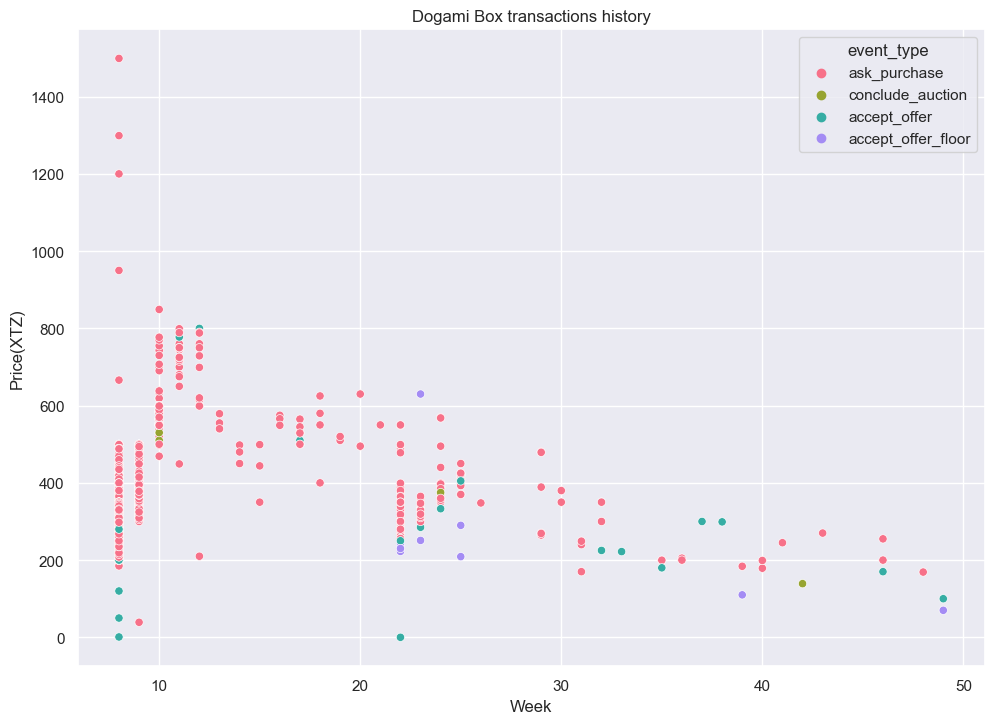

In [295]:
a=sns.scatterplot(box, x='Week', y='price',hue='event_type', palette='husl')
a.set(ylabel= 'Price(XTZ)',title='Dogami Box transactions history')

[Text(0.5, 1.0, 'Trade volume by event type(limited week)'),
 (10.0, 51.05),
 (0.0, 200.0)]

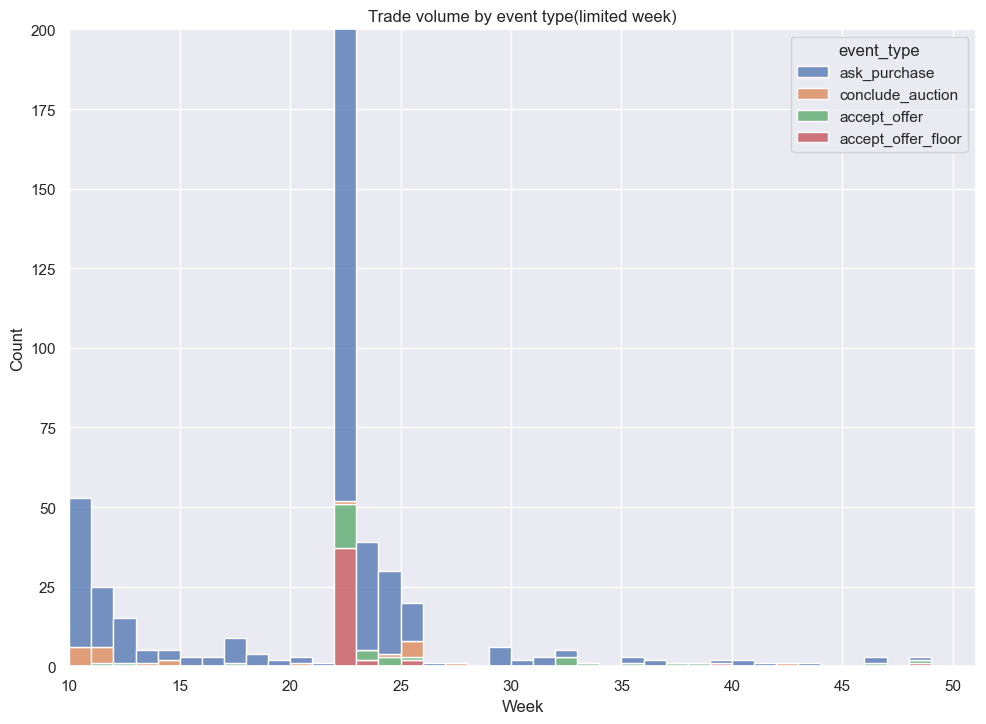

In [296]:
a = sns.histplot(box,x='Week',hue='event_type',multiple="stack",binwidth = 1)
a.set(title='Trade volume by event type(limited week)', xlim=(10, None), ylim = (0, 200))

In [271]:
Ptrade_final.columns

Index(['id', 'event_type', 'price', 'timestamp', 'token_pk',
       'recipient_address', 'creator_address', 'token.token_id', 'ts_new',
       'Week', 'token_id', 'Birthday', 'Rarity tier', 'Rarity score'],
      dtype='object')

<AxesSubplot:xlabel='Week', ylabel='price'>

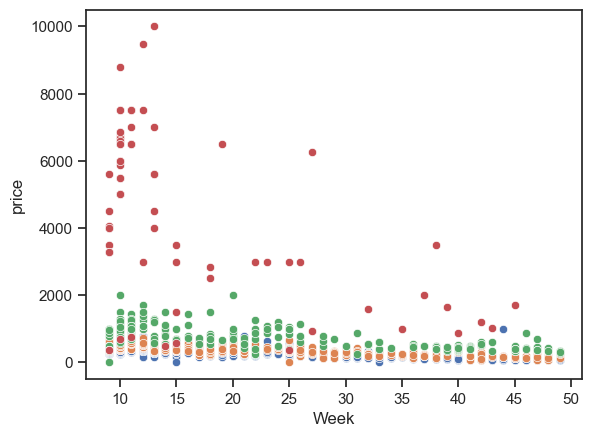

In [284]:
sns.scatterplot(Ptrade_final[Ptrade_final['Rarity tier']=='Bronze'], x='Week', y='price')
sns.scatterplot(Ptrade_final[Ptrade_final['Rarity tier']=='Silver'], x='Week', y='price')
sns.scatterplot(Ptrade_final[Ptrade_final['Rarity tier']=='Gold'], x='Week', y='price')
sns.scatterplot(Ptrade_final[Ptrade_final['Rarity tier']=='Diamond'], x='Week', y='price')

[Text(0.5, 1.0, 'Transaction of Bronze dogs')]

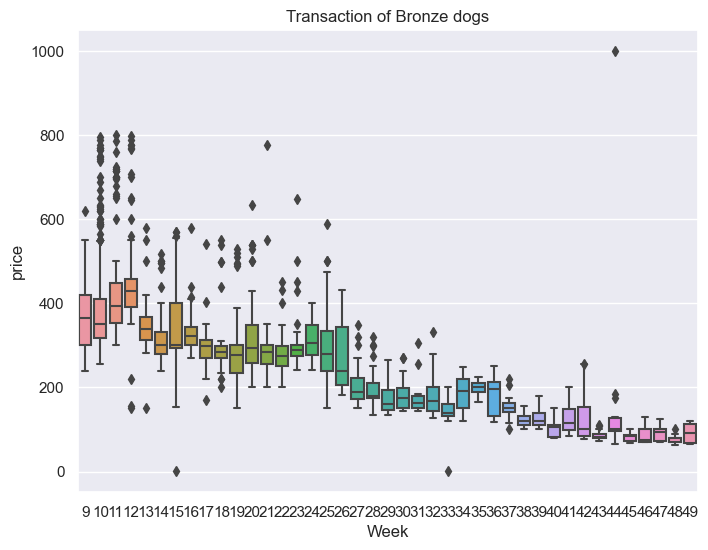

In [301]:
a = sns.boxplot(Ptrade_final[Ptrade_final['Rarity tier']=='Bronze'], x='Week', y='price')
#sns.set(rc={'figure.figsize':(8,6)})
a.set(title='Transaction of Bronze dogs')

[Text(0.5, 1.0, 'Transaction of Gold dogs')]

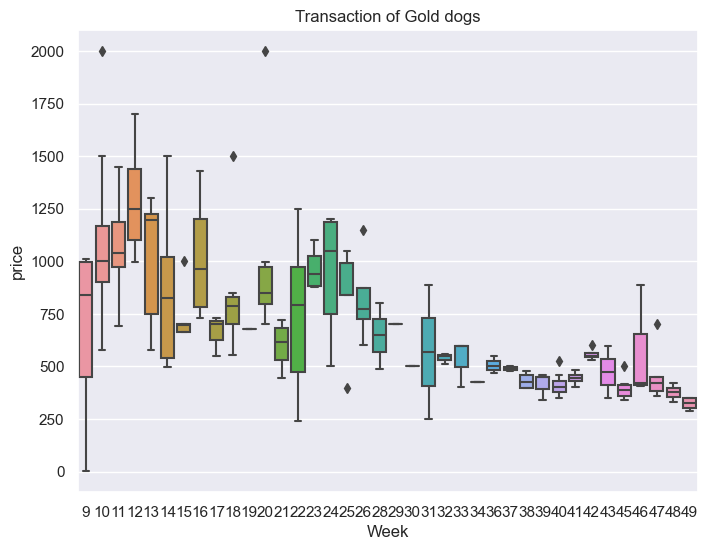

In [304]:
a = sns.boxplot(Ptrade_final[Ptrade_final['Rarity tier']=='Gold'], x='Week', y='price')
a.set(title='Transaction of Gold dogs')

[(0.0, 500.0)]

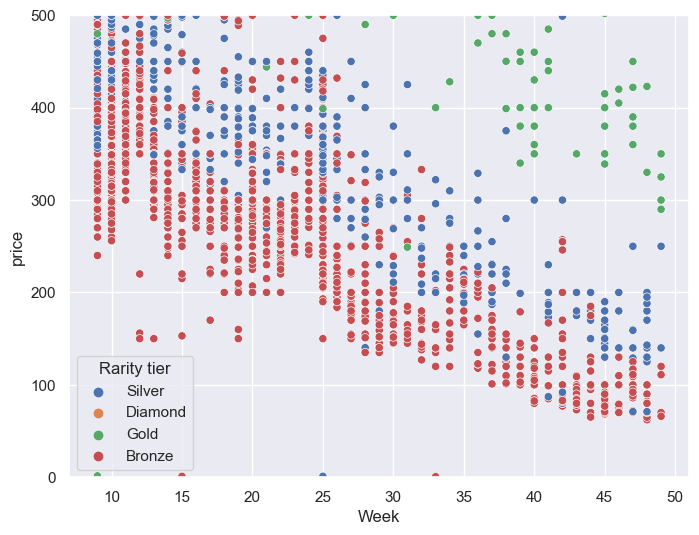

In [300]:
a = sns.scatterplot(Ptrade_final, x='Week', y='price', hue='Rarity tier')
a.set(ylim= (0,500))

In [267]:
Counter(Ptrade['Week']).most_common(20)

[(8, 922),
 (10, 582),
 (9, 554),
 (22, 230),
 (11, 204),
 (12, 168),
 (25, 135),
 (13, 104),
 (20, 94),
 (14, 88),
 (19, 82),
 (15, 70),
 (24, 69),
 (16, 68),
 (23, 66),
 (18, 65),
 (17, 63),
 (26, 62),
 (21, 57),
 (28, 48)]

In [250]:
Ptrade_final.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2794 entries, 0 to 2793
Data columns (total 14 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   id                 2794 non-null   float64       
 1   event_type         2794 non-null   object        
 2   price              2794 non-null   float64       
 3   timestamp          2794 non-null   object        
 4   token_pk           2794 non-null   float64       
 5   recipient_address  2794 non-null   object        
 6   creator_address    2794 non-null   object        
 7   token.token_id     2794 non-null   int64         
 8   ts_new             2794 non-null   datetime64[ns]
 9   Week               2794 non-null   int64         
 10  token_id           2794 non-null   int64         
 11  Birthday           2794 non-null   datetime64[ns]
 12  Rarity tier        2794 non-null   object        
 13  Rarity score       2794 non-null   float64       
dtypes: datet

In [251]:
box.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1869 entries, 0 to 5679
Data columns (total 10 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   id                 1869 non-null   float64       
 1   event_type         1869 non-null   object        
 2   price              1843 non-null   float64       
 3   timestamp          1869 non-null   object        
 4   token_pk           1869 non-null   float64       
 5   recipient_address  1843 non-null   object        
 6   creator_address    1869 non-null   object        
 7   token.token_id     1869 non-null   int64         
 8   ts_new             1869 non-null   datetime64[ns]
 9   Week               1869 non-null   int64         
dtypes: datetime64[ns](1), float64(3), int64(2), object(4)
memory usage: 225.2+ KB


In [16]:
Ptrade.drop(columns=0, inplace=True)

In [91]:
query = """query MyQuery {
  event(
    where: {fa: {contract: {_eq: "KT1NVvPsNDChrLRH5K2cy6Sc9r1uuUwdiZQd"}}, event_type: {_eq: "ask_purchase"}, token: {token_id: {_in: ["3","4"]}}}
  ) {
    id
    event_type
    price
    timestamp
    token_pk
    token {
      token_id
    }
    recipient_address
    creator_address
  }
}

"""
url = "https://data.objkt.com/v2/graphql"

In [99]:
r = requests.post(url, json={'query': query})
print(r.status_code)
json_data = json.loads(r.text)
type(json_data)
df = pd.json_normalize(json_data, record_path=['data','event'])
df.head()

200


,id,event_type,price,timestamp,token_pk,recipient_address,creator_address,token.token_id
0,2815223,conclude_auction,NaN,2022-02-28T07:48:34+00:00,10306,None,tz1YYX8bVLzfDYmhpUZ6oiZjqjw8aN23qd5N,3
1,22437837,ask_purchase,6.660000e+08,2022-02-22T22:27:50+00:00,10306,tz1YYX8bVLzfDYmhpUZ6oiZjqjw8aN23qd5N,tz1TVJBFaUg2Ki6dSJ5JqMQAAE4XVv1iQqvT,3
2,2856235,conclude_auction,NaN,2022-02-28T19:53:14+00:00,10306,None,tz1YYX8bVLzfDYmhpUZ6oiZjqjw8aN23qd5N,3
3,2893297,conclude_auction,NaN,2022-03-01T09:14:34+00:00,10306,None,tz1YYX8bVLzfDYmhpUZ6oiZjqjw8aN23qd5N,3
4,22490512,ask_purchase,1.200000e+09,2022-02-23T01:41:00+00:00,10691,tz2KJ784BBjQbxiSz6j8xcaR58PdSQZD15Gb,tz1XZ8qGWQ4MukcDsgrNzUZ9VubmCRZaYGMX,4


In [136]:
for i in [2,3,4,5]:
    print(i in [2,3,4])

True
True
True
False


In [4]:
df.to_excel("df.xlsx", sheet_name='ask purchase')

In [5]:
df["timestamp"].apply(lambda x: datetime.strptime(x, "%Y-%m-%dT%H:%M:%S+00:00").isoformat())[1]

'2022-08-10T03:10:29'

In [15]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   id          500 non-null    int64 
 1   event_type  500 non-null    object
 2   price       500 non-null    int64 
 3   timestamp   500 non-null    object
 4   token_pk    500 non-null    int64 
dtypes: int64(3), object(2)
memory usage: 19.7+ KB


In [94]:
query

'query MyQuery {\n  event(\n    where: {fa: {contract: {_eq: "KT1NVvPsNDChrLRH5K2cy6Sc9r1uuUwdiZQd"}}, event_type: {_eq: "ask_purchase"}, token: {token_id: {_in: ["3","4"]}}}\n  ) {\n    id\n    event_type\n    price\n    timestamp\n    token_pk\n    token {\n      token_id\n    }\n    recipient_address\n    creator_address\n  }\n}\n\n'

In [98]:
query = 'query MyQuery {\n  event(\n    where: {fa: {contract: {_eq: "KT1NVvPsNDChrLRH5K2cy6Sc9r1uuUwdiZQd"}}, event_type: {_in: ["ask_purchase","conclude_auction", "accept_offer","accept_offer_floor"]}, token: {token_id: {_in: '+'['+','.join(f'"{item}"' for item in puppies['token_id'][:5]) + ']'+'}}}\n  ) {\n    id\n    event_type\n    price\n    timestamp\n    token_pk\n    token {\n      token_id\n    }\n    recipient_address\n    creator_address\n  }\n}\n\n'
